# Predict delivery time for orders

First import necessary packages

In [1]:
import pandas as pd#to use dataframe
from datetime import datetime#to use datatime for conversion
import matplotlib.pyplot as plt#for plotting
from sklearn.model_selection import train_test_split#to split data into train and test
import seaborn as sb#for visualization 
from sklearn.linear_model import LinearRegression#for linear regression
from sklearn.metrics import mean_squared_error#to measure error between real prep time and predicted time
from sklearn import datasets, ensemble#to use gradientboostingregressor
import numpy as np#to use numpy arrays 
from sklearn.ensemble import RandomForestRegressor#to use random forest regressor
import matplotlib.pyplot as plt#to plot data
from sklearn.pipeline import Pipeline#to use standarscaler
from sklearn.preprocessing import StandardScaler#to normalize data
from sklearn.svm import SVR#to use support vector machines

# Read data

Read data into dataframes as it is very convenient to work on df

In [3]:
#a function to read data as df
def read_data(f_name_order, f_name_rest):
    """Read the data and return as a dataframe

    Parameters
    ----------
    f_name_order : str 
        The name of the file which contains order data
        
    f_name_rest : str 
        The name of the file which contains restaurant data

    returns: dataframe (df) and dataframe (df)
            The data for both order and restaurant as df which makes to process data easier

    Raises
    ------
    IOError
        If the file is not found

    """ 

    try:
        with open(f_name_order) as fobj:
            df_orders = pd.read_csv(f_name_order)
  
    except IOError:
        raise ValueError('File order is not available!')
        
    try:
        with open(f_name_rest) as fobj:
            df_rest = pd.read_csv(f_name_rest)
  
    except IOError:
        raise ValueError('File restaurant is not available!')


    return df_orders, df_rest


#read data
df_orders, df_rest = read_data("./data/orders.csv", "./data/restaurants.csv")
 
print("The total number of orders is ", len(df_orders))
print("The total number of restaurants is ", len(df_rest))
print("Feature names for orders data is as follows. ", df_orders.columns.values)
print("Feature names for restaurant data is as follows. ", df_rest.columns.values)


The total number of orders is  32394
The total number of restaurants is  1697
Feature names for orders data is as follows.  ['order_acknowledged_at' 'order_ready_at' 'order_value_gbp'
 'restaurant_id' 'number_of_items' 'prep_time_seconds']
Feature names for restaurant data is as follows.  ['restaurant_id' 'country' 'city' 'type_of_food']


# Pre-processing data

Let's first merge restaurant and order data by mapping a resturant id to its correspoding features from restaurants.csv. A restaurant id brings some other features such as type_of_food which might be important to predict the time so we need to include this in orders data.

In [4]:
df_data = df_rest.merge(df_orders, on = 'restaurant_id') 
df_data.head()

,restaurant_id,country,city,type_of_food,order_acknowledged_at,order_ready_at,order_value_gbp,number_of_items,prep_time_seconds
0,3,UK,London,thai,2015-06-01 21:27:40.365042+01:00,2015-06-01 21:48:46.831010+01:00,34.8,4,1266
1,3,UK,London,thai,2015-06-01 21:31:44.126128+01:00,2015-06-01 21:48:41.336221+01:00,140.3,11,1017
2,3,UK,London,thai,2015-06-01 21:38:14.914586+01:00,2015-06-01 21:48:57.693389+01:00,33.3,5,642
3,3,UK,London,thai,2015-06-01 21:35:27.039052+01:00,2015-06-01 21:48:52.124863+01:00,19.9,3,805
4,3,UK,London,thai,2015-06-01 21:46:37.890694+01:00,2015-06-01 21:48:35.800915+01:00,15.9,3,117


Now let's check data for missing features. If there were any missing features, we would remove them. But as can be seen, there are no missing features, so no need to drop any instances of features from our data.

In [5]:
print('The number of NaNs for each feature is as follows.\n') 
print(df_data.isna().sum())
print('\nThe number of nulls for each attribute is as follows. \n') 
print(df_data.isnull().sum())

The number of NaNs for each feature is as follows.

restaurant_id            0
country                  0
city                     0
type_of_food             0
order_acknowledged_at    0
order_ready_at           0
order_value_gbp          0
number_of_items          0
prep_time_seconds        0
dtype: int64

The number of nulls for each attribute is as follows. 

restaurant_id            0
country                  0
city                     0
type_of_food             0
order_acknowledged_at    0
order_ready_at           0
order_value_gbp          0
number_of_items          0
prep_time_seconds        0
dtype: int64


Let's map order_acknowledged_at feature (year, month, day, hour, minute, second) to only hour. This feature is important to understand the busy times of the restaurants which will have a huge impact on the delivery time. 
We will do this by mapping order_acknowledged_at to only hour information (as a categorical feature). This means we are making 24 time slots in a day to represent each hour of a day. 

We also plot histogram bins for time slots to understand which times are busy times for the restaurants. As depicted in figure below, the orders are mostly taken from 10 (AM) to 24 and the restaurants are usually busy from 18:00 to 21:00, which makes sense.
  

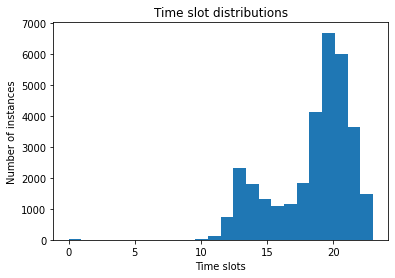

In [6]:
#do the time mapping
df_data['order_acknowledged_at'] = df_data['order_acknowledged_at'].apply(lambda x: pd.to_datetime(x).hour)
#plot the new categorical order_acknowledged_at feature.
df_data['order_acknowledged_at'].plot.hist(bins=24)
plt.title('Time slot distributions')
plt.xlabel('Time slots')
plt.ylabel('Number of instances')
plt.show() 

Now, let's remove the feature "order_ready_at" since it doesn't add any information. Prep_time_seconds already gives the same information.

In [7]:
df_data = df_data.drop(['order_ready_at'], axis=1)
df_data.head()

,restaurant_id,country,city,type_of_food,order_acknowledged_at,order_value_gbp,number_of_items,prep_time_seconds
0,3,UK,London,thai,21,34.8,4,1266
1,3,UK,London,thai,21,140.3,11,1017
2,3,UK,London,thai,21,33.3,5,642
3,3,UK,London,thai,21,19.9,3,805
4,3,UK,London,thai,21,15.9,3,117


Now, let's map the following features to numerical categories as they are categorical features

In [8]:
df_data['type_of_food'] = df_data['type_of_food'].astype('category').cat.codes
df_data['country'] = df_data['country'].astype('category').cat.codes
df_data['city'] = df_data['city'].astype('category').cat.codes

df_data.head()

,restaurant_id,country,city,type_of_food,order_acknowledged_at,order_value_gbp,number_of_items,prep_time_seconds
0,3,3,14,78,21,34.8,4,1266
1,3,3,14,78,21,140.3,11,1017
2,3,3,14,78,21,33.3,5,642
3,3,3,14,78,21,19.9,3,805
4,3,3,14,78,21,15.9,3,117


# Exploratory Data Analysis  

Except order_value_gp which is a real number, our features are categorical features. Now, let's visualize how features, their distributions and correlation with each other looks like. Firstly, let's start with visualizing correlation between features as a heatmap. The correlation values are numbers between -1 and 1. The negative sign means the features are inversely proportioned to each other and it is the opposite for the positive sign. The higher the number means higher the relationship. As can be seen in figure below, order_value_gbp and number_of_items have relatively higher correlation with each other and with prep_time_seconds, which makes sense. We cannot say there is a very high correlation between any features (>0.5). If it was the case, we would remove one of those features, as they wouldn't bring any information to the data. In other words, we would need to collinearity as Linear regression models we will use below would suffer from overfitting when there is high correlatation between features. 

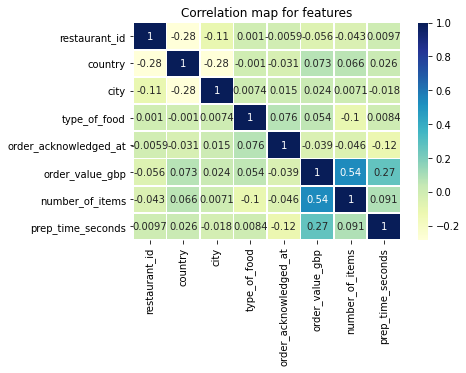

In [9]:
def show_feature_correlation(df):
    """Show a correlation of features as a heatmap

    Parameters
    ----------
    df : dataFrame
         data columns as feats where last column is labels

    """

    corr = df.corr()

    ax = plt.axes() 
    heat_map = sb.heatmap(corr, annot = True, cmap="YlGnBu", linewidths=.7, ax = ax)
    ax.set_title('Correlation map for features')
    plt.show()

show_feature_correlation(df_data)

Let's visualise some histogram bins to understand the distribution of some features. Just doing it for type of food below, could do some other features as well.

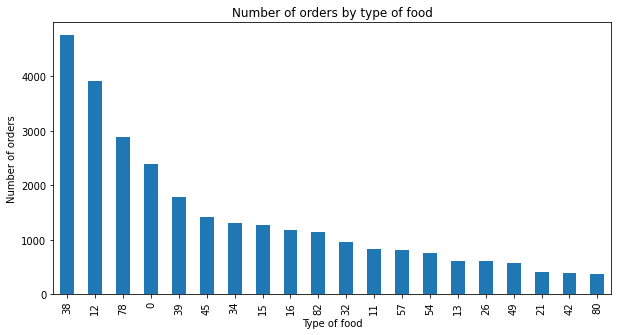

In [10]:
df_data.type_of_food.value_counts().nlargest(20).plot(kind='bar', figsize=(10,5))
plt.title("Number of orders by type of food")
plt.ylabel("Number of orders")
plt.xlabel("Type of food"); 

Let's see how preparation time in seconds change based on the food type. As we can see from figure below, the food sometimes the same type of food takes longer than usual. This might be related to other features such as order acknowledge time, the number of items, etc.

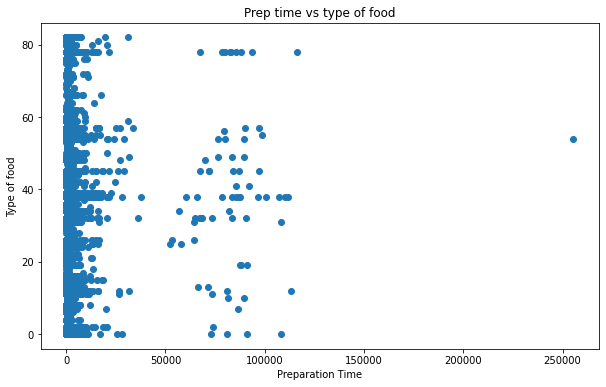

In [45]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(df_data["prep_time_seconds"], df_data["type_of_food"])
ax.set_xlabel("Preparation Time")
ax.set_ylabel("Type of food")
plt.title('Prep time vs type of food')
plt.show()

# Prepare train and test data

Let's write a function to split data into train and test.

In [12]:
def split_data(df, test_ratio):
    """Split data into train and test sets  

    Parameters
    ----------
    df : dataFrame
         data: columns as feats where last column is labels

    test_ratio: float
          percentage of test data to be splitted

    returns: pd.Series, pd.Series, pd.Series, pd.Series, 
             train features, test features, train labels and test labels

    """
    x_train, x_test, y_train, y_test = train_test_split(df_data.iloc[:,0:-1], df_data.iloc[:, -1],
                                                test_size = test_ratio)

    return x_train, x_test, y_train, y_test

### split train and test data - we use 0.2 as it is the convention
x_train, x_test, y_train, y_test = split_data(df_data, 0.2)

Let's normalize data using StandardScaler to obtain a better fit.

In [13]:
pipeline = Pipeline([('std_scalar', StandardScaler())])
x_train = pipeline.fit_transform(x_train)
x_test = pipeline.transform(x_test)

# Models to predict the preparation time

# 1) Linear regressor 

Our food preparation time resembles to house price prediction and linear regression is a popular method to predict house prices. Fit the model and predict on the test data and then print the Mean Squared Error (MSE) as it is a good metric to measure the differences between real value and the prediction.Rescale Inputs: Linear regression will often make more reliable predictions if you rescale input variables using standardization or normalization.

In [14]:
linear_reg = LinearRegression(normalize=True).fit(x_train, y_train)
y_pred_lr = linear_reg.predict(x_test)
print("MSE error using linear regression: ", mean_squared_error(y_test, y_pred_lr, squared = True))

MSE error using linear regression:  13880816.619565228


# 2) Gradient Boosting Regressor

Let's use Gradient Boosting Regressor from an ensemble of weak prediction models.  

In [15]:
params = {'n_estimators': 300,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}

gbr_reg = ensemble.GradientBoostingRegressor(**params)
gbr_reg.fit(x_train, y_train)
y_pred_gr = gbr_reg.predict(x_test)
print("MSE error using Gradient Boosting Regressor: ", mean_squared_error(y_test, y_pred_gr, squared = True))

MSE error using Gradient Boosting Regressor:  14405823.540991582


Let's see how estimators (the number of boosting stages) are changing the deviance for both train and test data.

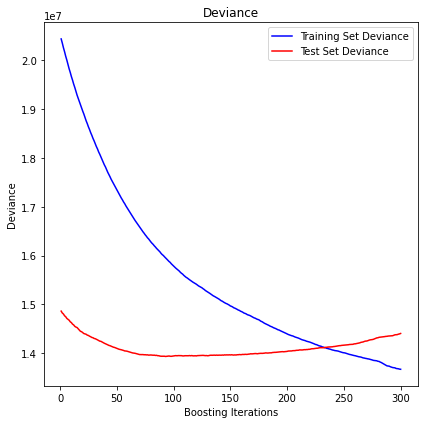

In [16]:
##let's visualize the change of deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred_gr in enumerate(gbr_reg.staged_predict(x_test)):
    test_score[i] = gbr_reg.loss_(y_test, y_pred_gr)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, gbr_reg.train_score_, 'b-',
         label='Training Set Deviance')

plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()

# 3) Random Forest Regressor

Let's also use a Random Forest Regressor to fit  decision trees.

In [17]:
rf_reg = RandomForestRegressor(max_depth=2, random_state=0)
rf_reg.fit(x_train, y_train)
y_pred_rf =  rf_reg.predict(x_test)
mse = mean_squared_error(y_test, y_pred_rf, squared = True)
print("MSE error using Random Forest Regression: ", mean_squared_error(y_test, y_pred_lr, squared = True))

MSE error using Random Forest Regression:  13880816.619565228


# 4) Support Vector Machine

In [40]:
svm_reg = SVR(kernel='rbf')
svm_reg.fit(x_train, y_train)
pred_svm = svm_reg.predict(x_test) 

mse = mean_squared_error(y_test, pred_svm, squared = True)
print("MSE error using SVM: ", mse)

MSE error using SVM:  15078565.240906794


In [ ]:
test_pred = model.predict(x_test)

mse = mean_squared_error(y_test, test_pred, squared = True)
print("MSE error using SVM: ", mse)

# Plot abs difference between real preparation times and the predicted times

Plot abs difference between real preparation times and the predicted times by three regressors, namely linear, gradientboosting, randomforest and SVM to understand which one is closer to the real preparation time.


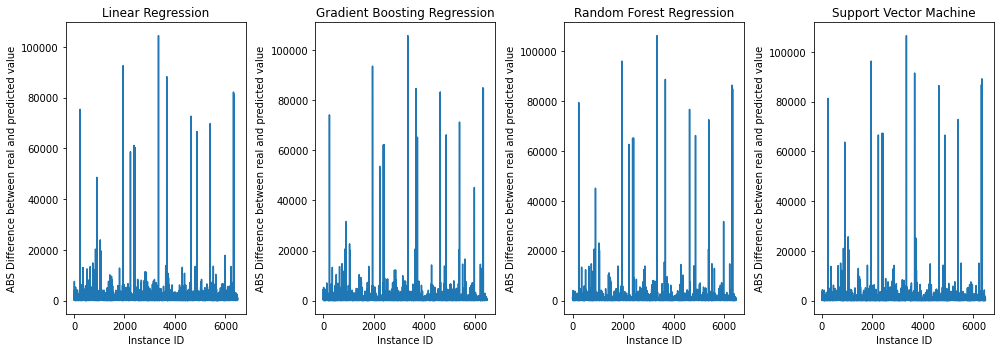

In [43]:
fig, ax = plt.subplots(1, 4, figsize=(14, 5))
ax[0].plot(np.arange(0, len(y_test)), np.abs(y_pred_lr-y_test))
ax[0].set_title("Linear Regression")
ax[0].set_xlabel("Instance ID")
ax[0].set_ylabel("ABS Difference between real and predicted value")

ax[1].plot(np.arange(0, len(y_test)), np.abs(y_pred_gr-y_test))
ax[1].set_title("Gradient Boosting Regression") 
ax[1].set_xlabel("Instance ID")
ax[1].set_ylabel("ABS Difference between real and predicted value")

ax[2].plot(np.arange(0, len(y_test)), np.abs(y_pred_rf-y_test))
ax[2].set_title("Random Forest Regression")
ax[2].set_xlabel("Instance ID")
ax[2].set_ylabel("ABS Difference between real and predicted value")


ax[3].plot(np.arange(0, len(y_test)), np.abs(pred_svm-y_test))
ax[3].set_title("Support Vector Machine")
ax[3].set_xlabel("Instance ID")
ax[3].set_ylabel("ABS Difference between real and predicted value")

fig.tight_layout()

# Conclusion and Future Work

The results show there is not a clear winner. The difference plots (plot above) and figure named "Prep time vs type of food" shows that there is outliers in this data. 'Prep time vs type of food' figure tells the same type of food takes much longer than usual for some orders and the figure above shows the models almost perform bad on same orders, most probably these are the outliers. Removing the outliers from data can be future work and then the same analysis could be performed.

Future Work
1. Remove outliers from data.
2. We can try to optimize the parameters for the models.
3. We can normalize features using Min-Max scale instead of using standard normalization.
4. We can use 10-fold cross validation to understand which method is more robust when train and test data changes.
5. We can use other error metrics  such as Mean Absolute Error to compare the models.
6. Interpreting the coefficients can be done  for linear regression,
7. Perform feature selection to see which ones are better for a good prediction.
8. Grid search can be done to fine tune hyper-parameters of SVM.